# EPC100Maps
This notebook contains scripts for plotting maps of EPC at 100 m from CMIP6 models

## Imports and settings

In [1]:
import xarray as xr
from dask.distributed import Client, LocalCluster
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cmocean.cm as cmo
import numpy as np
import matplotlib.tri as tri
import matplotlib
import cftime
from glob import glob

# Set plotting defaults
plt.rc('font', family='serif', size='14')
plt.rc('xtick', labelsize='9')
plt.rc('ytick', labelsize='9')
plt.rcParams['axes.titlesize'] = 14
fmt = matplotlib.ticker.ScalarFormatter(useMathText=True)

## Plotting of time slices
The below code will plot spatial time slice of the decadally averaged `epc100` for the first and last decade of each model run. It will also plot the difference between the two.

In [4]:
data_dir = '/gws/pw/j05/cop26_hackathons/bristol/project03/input_nc/multimodel/ssp370/'
file_prefix = 'epc100_Omon_'
model_names = ['CMCC-ESM2', 'GFDL-ESM4', 'IPSL-CM5A2-INCA', 'IPSL-CM6A-LR', 'MPI-ESM-1-2-HAM',
               'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR']
glob_suffix = '*.nc'

model_paths = [data_dir + file_prefix + model_name + glob_suffix for model_name in model_names]
model_paths

['/gws/pw/j05/cop26_hackathons/bristol/project03/input_nc/multimodel/ssp370/epc100_Omon_CMCC-ESM2*.nc',
 '/gws/pw/j05/cop26_hackathons/bristol/project03/input_nc/multimodel/ssp370/epc100_Omon_GFDL-ESM4*.nc',
 '/gws/pw/j05/cop26_hackathons/bristol/project03/input_nc/multimodel/ssp370/epc100_Omon_IPSL-CM5A2-INCA*.nc',
 '/gws/pw/j05/cop26_hackathons/bristol/project03/input_nc/multimodel/ssp370/epc100_Omon_IPSL-CM6A-LR*.nc',
 '/gws/pw/j05/cop26_hackathons/bristol/project03/input_nc/multimodel/ssp370/epc100_Omon_MPI-ESM-1-2-HAM*.nc',
 '/gws/pw/j05/cop26_hackathons/bristol/project03/input_nc/multimodel/ssp370/epc100_Omon_MPI-ESM1-2-HR*.nc',
 '/gws/pw/j05/cop26_hackathons/bristol/project03/input_nc/multimodel/ssp370/epc100_Omon_MPI-ESM1-2-LR*.nc']

In [17]:
def regrid_and_plot(ax, da, cmap=cmo.algae, vmin=0, vmax=1.75e-7):
    Z = da.values.ravel()
    interp_lin = tri.LinearTriInterpolator(triangles, Z)
    Z_interp = interp_lin(X_interp, Y_interp)

    cax = ax.pcolormesh(X_interp, Y_interp, Z_interp,
                        transform=ccrs.PlateCarree(),  # For some reason this always has to be ccrs.PlateCarree(), no idea why...
                        cmap=cmap,
                        vmin=vmin, vmax=vmax)
    cb = plt.colorbar(cax, ax=ax, format=fmt, orientation='horizontal')
    ax.coastlines()

/home/users/train019/.conda/envs/jupy/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/train019/.conda/envs/jupy/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/train019/.conda/envs/jupy/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
/home/users/train019/.conda/envs/jupy/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/train019/.conda/envs/jupy/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/train019/.conda/envs/jupy/lib/py

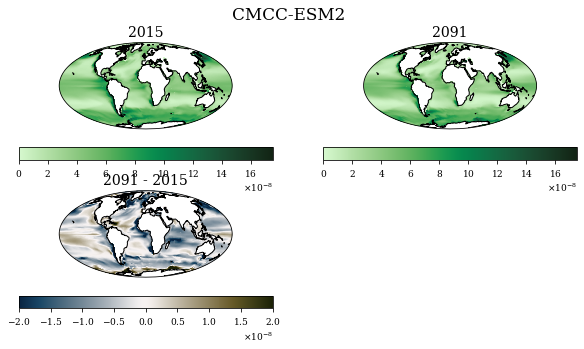

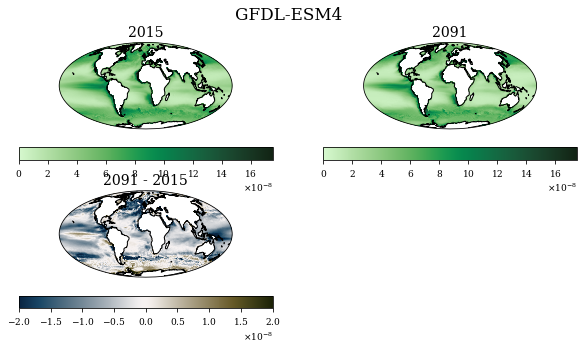

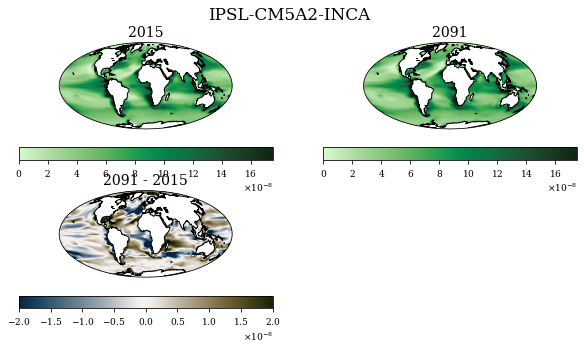

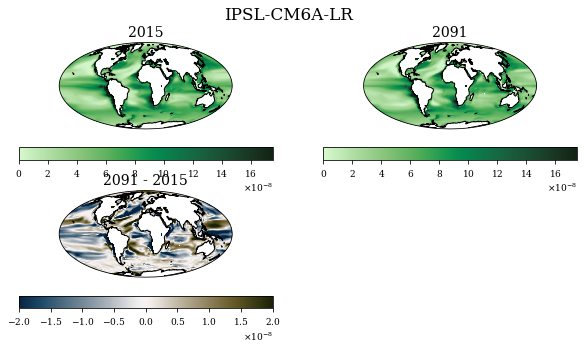

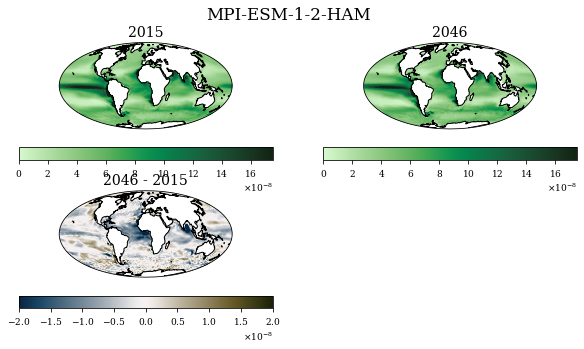

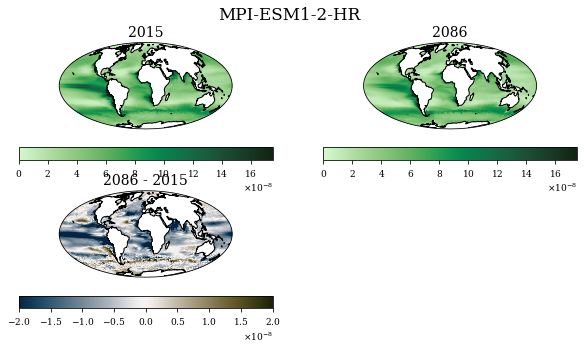

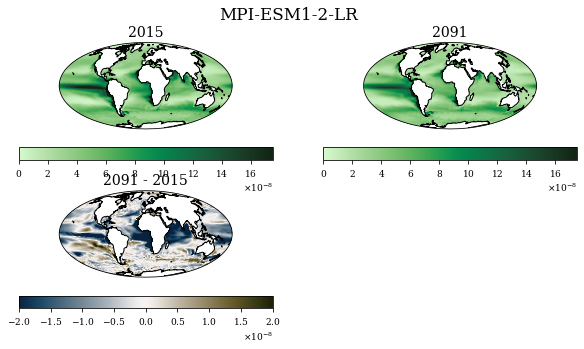

In [47]:
for model_name in model_names:
    model_path = data_dir + file_prefix + model_name + glob_suffix
    file_paths = glob(model_path)
    da = xr.open_mfdataset(file_paths)['epc100']

    da_start_decadal_mean = da.isel(time=slice(120)).mean(dim='time')
    da_end_decadal_mean = da.isel(time=slice(-120, da['time'].size)).mean(dim='time')

    # Identify the lat and lon coordinates
    try:
        lon = da['longitude']
        lat = da['latitude']
    except KeyError:
        try:
            lon = da['lon']
            lat = da['lat']
        except KeyError:
            lon = da['nav_lon']
            lat = da['nav_lat']
        
    X, Y = lon.values, lat.values
    X[X > 180] -= 360
    
    # Make X and Y meshgrids if not already
    if len(lon.shape) == 1:
        X, Y = np.meshgrid(X, Y)    
    
    X_interp, Y_interp = np.meshgrid(np.linspace(-180, 180, 360), np.linspace(-90, 90, 330))
    triangles = tri.Triangulation(X.ravel(), Y.ravel())
        
    ## Plotting function call here.
    fig, axs = plt.subplots(2, 2, subplot_kw={'projection': ccrs.Mollweide(central_longitude=0)}, figsize=(10, 5))

    axs[1, 1].axis('off')


    regrid_and_plot(axs[0, 0], da_start_decadal_mean)
    regrid_and_plot(axs[0, 1], da_end_decadal_mean)
    regrid_and_plot(axs[1, 0], da_end_decadal_mean - da_start_decadal_mean, cmap=cmo.diff, vmin=-2e-8, vmax=2e-8)

    axs[0, 0].set_title(da['time.year'].isel(time=0).values)
    axs[0, 1].set_title(da['time.year'].isel(time=-120).values)
    axs[1, 0].set_title('{} - {}'.format(da['time.year'].isel(time=-120).values, da['time.year'].isel(time=0).values))
    fig.suptitle(model_name)
    fig.tight_layout()
    fig.show()

    file_name = '/gws/pw/j05/cop26_hackathons/bristol/project03/output_nc/export_timeslice_decadally_averaged_' + model_name + '_ssp370_r1irp1f2_epc100.nc'
    da_decadally_averaged = xr.concat([da_start_decadal_mean, da_end_decadal_mean], dim=da['time.year'].isel(time=[0, -120]))
    ds = xr.Dataset({'decadally_averaged_epc100': da_decadally_averaged})
    ds.to_netcdf(file_name)

In [32]:
file_name = '/gws/pw/j05/cop26_hackathons/bristol/project03/export/export_timeslice_regridded_decadally_averaged' + model_name + '_r1irp1f2_epc100.nc'
file_name

'/gws/pw/j05/cop26_hackathons/bristol/project03/export/export_timeslice_regridded_decadally_averagedMPI-ESM1-2-LR_r1irp1f2_epc100.nc'

In [133]:
len(da['lon'].dims)

1

In [42]:
da_decadally_averaged_regridded = xr.concat([da_start_decadal_mean, da_end_decadal_mean], dim=da['time.year'].isel(time=[0, -120]))
ds = xr.Dataset({'decadally_averaged_regridded_epc100': da_decadally_averaged_regridded})
ds

<xarray.Dataset>
Dimensions:                              (i: 256, j: 220, time: 2)
Coordinates:
  * time                                 (time) datetime64[ns] 2015-01-16T12:...
  * j                                    (j) int32 0 1 2 3 4 ... 216 217 218 219
  * i                                    (i) int32 0 1 2 3 4 ... 252 253 254 255
    latitude                             (j, i) float64 dask.array<chunksize=(220, 256), meta=np.ndarray>
    longitude                            (j, i) float64 dask.array<chunksize=(220, 256), meta=np.ndarray>
    depth                                float64 100.0
    year                                 (time) int64 2015 2091
Data variables:
    decadally_averaged_regridded_epc100  (time, j, i) float32 dask.array<chunksize=(1, 220, 256), meta=np.ndarray>

In [45]:
data_dir = '/gws/pw/j05/cop26_hackathons/bristol/project03/input_nc/multimodel/ssp370/'
file_prefix = 'epc100_Omon_'
model_names = ['CMCC-ESM2', 'GFDL-ESM4', 'IPSL-CM5A2-INCA', 'IPSL-CM6A-LR', 'MPI-ESM-1-2-HAM',
               'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR']
glob_suffix = '*.nc'

model_paths = [data_dir + file_prefix + model_name + glob_suffix for model_name in model_names]
model_paths

for model_name in model_names:
    model_path = data_dir + file_prefix + model_name + glob_suffix
    file_paths = glob(model_path)
    da = xr.open_mfdataset(file_paths)['epc100']
    print(model_name, da.units)

CMCC-ESM2 mol m-2 s-1
GFDL-ESM4 mol m-2 s-1
IPSL-CM5A2-INCA mol m-2 s-1
IPSL-CM6A-LR mol m-2 s-1
MPI-ESM-1-2-HAM mol m-2 s-1
MPI-ESM1-2-HR mol m-2 s-1
MPI-ESM1-2-LR mol m-2 s-1


In [54]:
def regrid_and_plot(ax, da, cmap=cmo.algae, vmin=0, vmax=1.75e-7):
    Z = da.values.ravel()
    interp_lin = tri.LinearTriInterpolator(triangles, Z)
    Z_interp = interp_lin(X_interp, Y_interp)

    cax = ax.pcolormesh(X_interp, Y_interp, Z_interp,
                        transform=ccrs.PlateCarree(),  # For some reason this always has to be ccrs.PlateCarree(), no idea why...
                        cmap=cmap,
                        vmin=vmin, vmax=vmax)
    ax.coastlines()
    return cax

/home/users/train019/.conda/envs/jupy/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/train019/.conda/envs/jupy/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/train019/.conda/envs/jupy/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/train019/.conda/envs/jupy/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/train019/.conda/envs/jupy/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/train019/.conda/envs/jupy/lib/python3.7/site-packages/dask/array/numpy_co

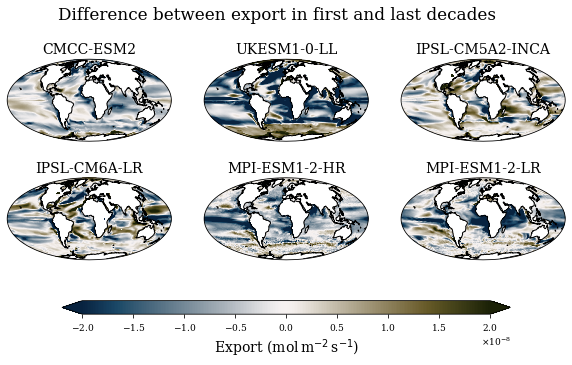

In [77]:
model_names = ['CMCC-ESM2', 'UKESM1-0-LL', 'IPSL-CM5A2-INCA', 'IPSL-CM6A-LR',
               'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR']

fig, axs = plt.subplots(2, 3, subplot_kw={'projection': ccrs.Mollweide(central_longitude=0)}, figsize=(10, 5))
axs = axs.flatten()
for ii in range(6):
    model_name = model_names[ii]
    if model_name == 'UKESM1-0-LL':
        model_path = '/gws/pw/j05/cop26_hackathons/bristol/project03/input_nc/UKESM1-0-LL/epc100_Omon_UKESM1-0-LL_ssp370_r1i1p1f2_gn*.nc'
    else:
        model_path = data_dir + file_prefix + model_name + glob_suffix
    file_paths = glob(model_path)
    da = xr.open_mfdataset(file_paths)['epc100']

    da_start_decadal_mean = da.isel(time=slice(120)).mean(dim='time')
    da_end_decadal_mean = da.isel(time=slice(-120, da['time'].size)).mean(dim='time')

    # Identify the lat and lon coordinates
    try:
        lon = da['longitude']
        lat = da['latitude']
    except KeyError:
        try:
            lon = da['lon']
            lat = da['lat']
        except KeyError:
            lon = da['nav_lon']
            lat = da['nav_lat']
        
    X, Y = lon.values, lat.values
    X[X > 180] -= 360
    
    # Make X and Y meshgrids if not already
    if len(lon.shape) == 1:
        X, Y = np.meshgrid(X, Y)    
    
    X_interp, Y_interp = np.meshgrid(np.linspace(-180, 180, 360), np.linspace(-90, 90, 330))
    triangles = tri.Triangulation(X.ravel(), Y.ravel())
        
    ## Plotting function call here.
    cax = regrid_and_plot(axs[ii], da_end_decadal_mean - da_start_decadal_mean, cmap=cmo.diff, vmin=-2e-8, vmax=2e-8)

    axs[ii].set_title(model_name)

#    file_name = '/gws/pw/j05/cop26_hackathons/bristol/project03/output_nc/export_timeslice_decadally_averaged_' + model_name + '_ssp370_r1irp1f2_epc100.nc'
#    da_decadally_averaged = xr.concat([da_start_decadal_mean, da_end_decadal_mean], dim=da['time.year'].isel(time=[0, -120]))
#    ds = xr.Dataset({'decadally_averaged_epc100': da_decadally_averaged})
#    ds.to_netcdf(file_name)
cb = fig.colorbar(cax, ax=axs, orientation='horizontal', extend='both', fraction=0.05, aspect=30, format=fmt)
cb.set_label('Export (mol$\,$m$^{-2}\,$s$^{-1}$)')
fig.tight_layout()
fig.suptitle('Difference between export in first and last decades')

fig.show()

In [78]:
fig.savefig('ExportDifferences.pdf')